In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt
from sklearn import preprocessing
from sklearn.datasets import fetch_mldata
import sklearn.linear_model
import random
%matplotlib inline
np.random.seed(314)
random.seed(314)

# Generate training set from a random distribution

We start the tutorial by generating a training set. We generate 4000 points, from 2 multivariate distributions (with different covariance and mean), and we label them with 0, respectively 1. Both classes are totally balanced having each 2000 points. Because the data is in the same scale, we do not need to do a standardization of the features, so we leave them as they are. Finally, we plot the points in such a way that points with different labels have different colors.

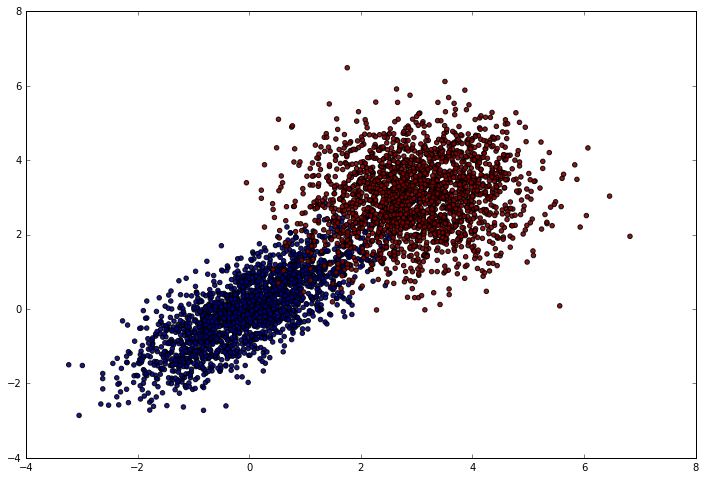

In [7]:
num_observations = 2000

x1 = np.random.multivariate_normal([0, 0], [[1, .75], [.75, 1]], num_observations)
x2 = np.random.multivariate_normal([3, 3], [[1, .1], [.1, 1]], num_observations)

training_set = np.vstack((x1, x2)).astype(np.float32)
training_labels = np.hstack((np.zeros(num_observations),
                             np.ones(num_observations)))

plt.figure(figsize=(12, 8))
plt.scatter(training_set[:, 0], training_set[:, 1],
            c=training_labels, alpha=.9)

# Logistic Regression

We have already explained logistic regression in the blackboard. Below, we define a class that implements a minimal version of logistic regression. The class has only four methods:
    - loss_function - the method that computes the loss/cost function and the gradient, given a batch of data.
    - train - the method which trains the algorithm. You need to pass to this method a training set and its labels, while as optional parameters you can also pass the number of epochs and the learning rate.
    - predict - the method which predicts the labels, given a new unlabeled set. This method should be called after the classifier is trained, or by passing a theta to classifier, using classifier._theta
    - test_accuracy - the method which measures the accuracy of the classifier given the predicted labels and the real labels.
    
We also defined a sigmoid function which simply computes the sigmoid of a data structure (it works with scalars, arrays and multidimensional arrays).    

In [8]:
def SGD(X, y, alpha, grad, loss_function, initial_theta, batch_size=1, tol=1e-5, max_iter=10000, verbose=False):
    """
       This function estimates a set of parameters 
       using the stochastic gradient descent (SGD) method.
       :param X: the observation matrix.
       :param y: the targets of the observations.
       :param alpha: the learning parameter. Lower values
              correspond to slower convergence but prevent
              overshooting.
       :param grad: function specifying the gradient of the
              function to be minimized.
       :param batch_size: the size of the batch to perform a
              single update of the parameters. If
              batch_size = 1 the algorithm performs the
              stochastic gradient descent in its original
              form, if batch_size >= X.shape[0] the
              algorithm performs the batch gradient descent.
       :param tol: the error tolerance. If the norm of
              of the difference vector between
              the parameter vectors at time t and
              t - 1 is lower than tol, the 
              algorithm stops.
       :param max_iter: the maximum number of
              iterations. The algorithm stops
              if this number of iterations is reached.
       :param verbose: if set to True, it computes the
              loss function and 
       :return theta: the parameter array
    """

    # initialization of parameters
    n, k = X.shape
    batches = range(0, n, batch_size)
    theta = initial_theta
    theta_old = np.full(theta.shape, np.inf)
    epochs = 0
    print_epoch_n = max_iter / 10

    while (np.linalg.norm(theta - theta_old) > tol) and (epochs < max_iter):
        epochs += 1
        
        # copy beta
        theta_old = theta.copy()

        # shuffle the batch to avoid bias
        random.shuffle(batches)

        for i in batches:
            xs, ys = (X[i:(i + batch_size), :], y[i:(i + batch_size)])
            theta -= alpha * grad(xs, ys, theta)
        
        if verbose and (epochs % print_epoch_n == 0):
            print("Loss function at step %d is: %g" % (epochs, loss_function(xs, ys, theta)))

    return theta

In [9]:
def sigmoid(x):
    """
       compute the sigmoid function
       
       inputs:
       - x: an ndarray of values, to compute
            the sigmoid on.
       
       outputs:
       - an ndarray of the same shape of x
         with the sigmoid evaluated for
         all elements of x.
    """
    return 1.0 / (1.0 + np.exp(-x))


class LogisticRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        self._theta = None

    def loss_function(self, X, y, theta):
        """
           compute the logistic regression
           loss function and its gradient
           for the hypothesis the labels y.
           
           inputs:
           - y: the targets of the observations
           
           outputs:
           - the loss function
        """
        
        hypothesis = sigmoid(np.dot(X, theta))
        return (-1.0 / y.shape[0]) * np.sum(np.dot(y.T, np.log(hypothesis)) +
                                            np.dot((1.0 - y.T), np.log(1.0 - hypothesis)))

    def gradient(self, X, y, theta):
        """
           compute the gradient of the loss function
           for the observation matrix X and the labels y.
           
           inputs:
           - X: the observation matrix X
           - y: the targets of the observations
           
           outputs:
           - the gradient of the loss function
        """
        
        hypothesis = sigmoid(np.dot(X, theta))
        return (1.0 / y.shape[0]) * np.dot((hypothesis - y).T, X).T

    def train(self, X, y, alpha=0.1, batch_size=1, tol=1e-5, max_iter=10001, verbose=False):
        """
           train the classifier with the SGD method
           
           inputs:
           - X: the observation matrix X
           - y: the targets of the observations
           - alpha: the learning rate
           - batch_size: the size of a single batch
           - tol: the error tolerance
           - max_iter: the maximum number of iterations
           - verbose: if set to True the loss function is printed
                      to check if the algorithm is converging
        """
        
        if self.add_bias:
            X = np.hstack((np.ones((X.shape[0], 1)), X))
        theta0 = np.zeros((X.shape[1],))
        self._theta = SGD(X, y, alpha, self.gradient, self.loss_function, theta0, batch_size, tol, max_iter, verbose)
        
    def predict(self, X):
        """
           predict the labels for the observation matrix X
           
           inputs:
            - X: the observation matrix
            
           outputs:
            - predicted: ndarray of predicted labels
        """
        if self.add_bias:
            X = np.hstack((np.ones((X.shape[0], 1)), X))

        predicted = np.round(sigmoid(np.dot(X, self._theta)))
        return predicted

    def test_accuracy(self, predicted, labels):
        """
           compute the accuracy of the predictions given
           a set of labels
           
           inputs:
           - predict: ndarray of predicted labels
           - labels: ndarray of real labels
           
           outputs:
           - the accuracy
        """
        return np.sum(labels == predicted) / float(len(labels))

Below we build an object from the LogisticRegression class, and then we call its train method, passing as arguments a training set and training labels

In [10]:
lr = LogisticRegression()
lr.train(training_set, training_labels, alpha=0.1, batch_size=training_set.shape[0], tol=1e-10, max_iter=10001, verbose=True)

Loss function at step 1000 is: 0.122355
Loss function at step 2000 is: 0.112022
Loss function at step 3000 is: 0.108922
Loss function at step 4000 is: 0.107628
Loss function at step 5000 is: 0.107001
Loss function at step 6000 is: 0.106672
Loss function at step 7000 is: 0.10649
Loss function at step 8000 is: 0.106385
Loss function at step 9000 is: 0.106324
Loss function at step 10000 is: 0.106287


Below, we generate a testing set from the same distributions we generated the training set. We generate 2 thousand points and we visualize them. We also generate labels in order to be able to see the accuracy of our classifier.

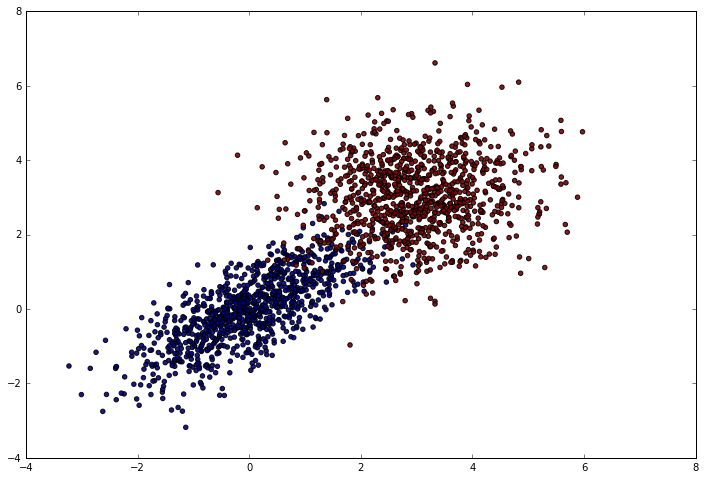

In [11]:
num_observations = 1000
x1 = np.random.multivariate_normal([0, 0], [[1, .75], [.75, 1]], num_observations)
x2 = np.random.multivariate_normal([3, 3], [[1, .1], [.1, 1]], num_observations)

testing_set = np.vstack((x1, x2)).astype(np.float32)
testing_labels = np.hstack((np.zeros(num_observations),
                            np.ones(num_observations)))

plt.figure(figsize=(12, 8))
plt.scatter(testing_set[:, 0], testing_set[:, 1],
            c=testing_labels, alpha=.9)

We predict the labels of the testing set, and we print the accuracy of the classifier on this dataset.

In [12]:
pred = lr.predict(testing_set)
accuracy = lr.test_accuracy(pred, testing_labels)
print("The accuracy is: %g" % accuracy)

The accuracy is: 0.961


Finally, we plot the data points in such a way that the points which have been classified correctly are plotted with the blue color, while incorrectly classified points are plotted with the red color.

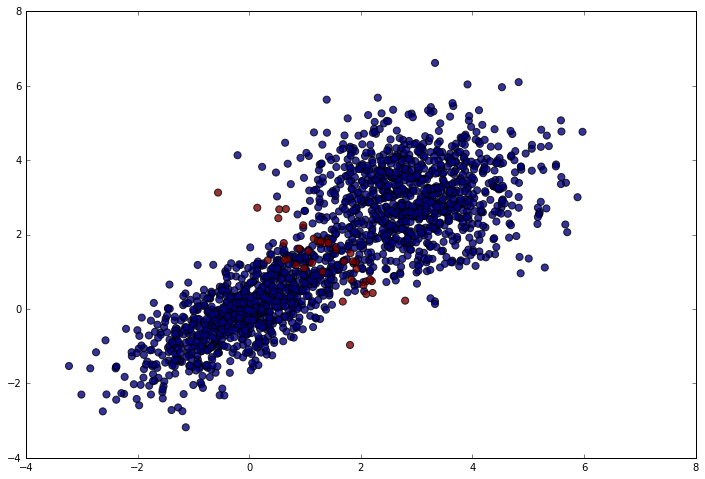

In [13]:
plt.figure(figsize=(12, 8))
plt.scatter(testing_set[:, 0], testing_set[:, 1],
            c=pred == testing_labels - 1, alpha=.8, s=50)

# What if we want to use logistic regression in a real-world dataset?

What we've done so far is cute, but utterly pointless. Synthetic datasets aren't very interesting (I know at least one person who would strongly disagree with that statement) and the dataset had just 2 features meaning that it can be classified as well by visual inspection (fun fact: if all datasets were on 2d space, then machine learning would have been a discipline on mathematical analysis instead of an applied science). It would be more interesting to test our algorithm in a more challenging real-world dataset.

For this experiment, we chose Haberman dataset - can be downloaded from: https://archive.ics.uci.edu/ml/datasets/Haberman's+Survival - which is a dataset with information about cancer survivability.

The dataset has 3 features:
   1. Age of patient at time of operation (numerical)
   2. Patient's year of operation (year - 1900, numerical)
   3. Number of positive axillary nodes detected (numerical)
and of course the label where:
   1 means that the patient survived for at least 5 years while
   2 means that the patient died within 5 years 
   
We load the dataset, randomly split it into training and testing, and finally (for simplicity) we replace all 2s in labels with 0s.   

In [14]:
haberman = np.loadtxt("haberman.txt", delimiter=',')
np.random.shuffle(haberman)
haberman_train = haberman[:250, :-1]
labels_train = haberman[:250, -1]
haberman_test = haberman[250:, :-1]
labels_test = haberman[250:, -1]

labels_test[labels_test == 2] = 0
labels_train[labels_train == 2] = 0

## Standardizing the dataset

We standardize the datasets (making the dataset having 0 mean and 1 standard deviation, aka putting each feature in the same scale) using preprocessing package. You can see that for the standardization, we compute the statistics (mean and std) using only the training set, and we apply the same statistics in both the training set and the testing set. The reason for that is beyond the scope of this lecture, and will be covered when we will study generalization and overfitting.

Finally, we print the mean and std of the both training and testing set after those sets have been standardized. We see that the mean and std in the training set are 0 and 1, but in the testing set are slightly different numbers.

In [15]:
# preprocess the data
scaler = preprocessing.StandardScaler().fit(haberman_train)
haberman_train = scaler.transform(haberman_train)
haberman_test = scaler.transform(haberman_test)

# check if the mean and std are 0/1
print(np.mean(haberman_train), np.std(haberman_train), np.mean(haberman_test), np.std(haberman_test))

(-2.3684757858670006e-16, 0.99999999999999967, -0.071084363379279689, 0.81180064753754055)


As before, we train the classifier in the training set, predict the labels of the testing set, and finally, we compute the accuracy of the classifier in this dataset.

In [16]:
# train, predict and test
lr = LogisticRegression()
theta = lr.train(haberman_train, labels_train, batch_size=haberman_train.shape[0], tol=1e-10, verbose=True)
pred = lr.predict(haberman_test)
accuracy = lr.test_accuracy(pred, labels_test)
print("The accuracy is: %g" % accuracy)

Loss function at step 1000 is: 0.548906
The accuracy is: 0.821429


In [19]:
from sklearn import linear_model

logreg = linear_model.LogisticRegression()
logreg.fit(haberman_train, labels_train)
pred = logreg.predict(haberman_test)
print("The accuracy using sklearn logistic regression is: %g" % 
      (np.sum(labels_test == pred) / float(len(labels_test))))

The accuracy using sklearn logistic regression is: 0.821429


## Comparing our classifier with sklearn logistic regression classifier

Building classifiers from scratch (unless no-one smart has implemented the classifier before) is not really a genial idea. It is usually done for educational reasons (like this one), but for most problems, you are going to use a classifier from an existing library. On Python - unless you are working with neural networks - that library is sklearn. Sklearn is an awesome machine learning library, which offers a lot of algorithms like linear and logistic regression, SVM, Random Forests, AdaBoost, Clustering Algorithms and Dimensionality Reduction Algorithms. 

On this part, we are going to compare our results with the results of the logistic regression classifier algorithm from sklearn.

The accuracy is the same. Surprising? Not really. The error function of logistic regression (called cross entropy) is a convex function, which on layman terms it means that you are guaranteed to find the optimal solution providing that you use a large number of iterations and a not very large learning rate. While this doesn't neccesarily mean that the results on the testing set will be exactly the same (that would generate a debate that may include convex optimization, Bayesian statistics and learning theory), until we cover regularization and generalization, we will assume that.

# Dealing with multiple classes

What if we have more than 2 classes? In fact, almost every time you are going to classify a dataset, you will have more than 2 classes there. While this can be done with logistic regression classifier, some changes are needed.

There exist 2 ways of using logistic regression for multiple classes:
    - One vs all logistic regression. The idea here is quite simple, if you have m classes, train m classifiers, each of them having as positive examples, the examples coming from a single class, and as negative examples, all the other examples. In the end, you do the prediction in all of them, and you define that a point belong in a certain class by doing an argmax over the predictions of all the classifiers. Personally, I find this method incredibly stupid (when used on logistic regression), annoying and slow to work.
    
    - Softmax Classifier (if on Deep Learning), Multinomial Logistic Regression (if on Machine Learning), LogSumExp Classifier (if on Statistics). For this lecture - and everytime I am in class - we are going to call it softmax classifier. Softmax Classifier is just a generalization of logistic regression, which deals with multiple classes

# Softmax Classifier

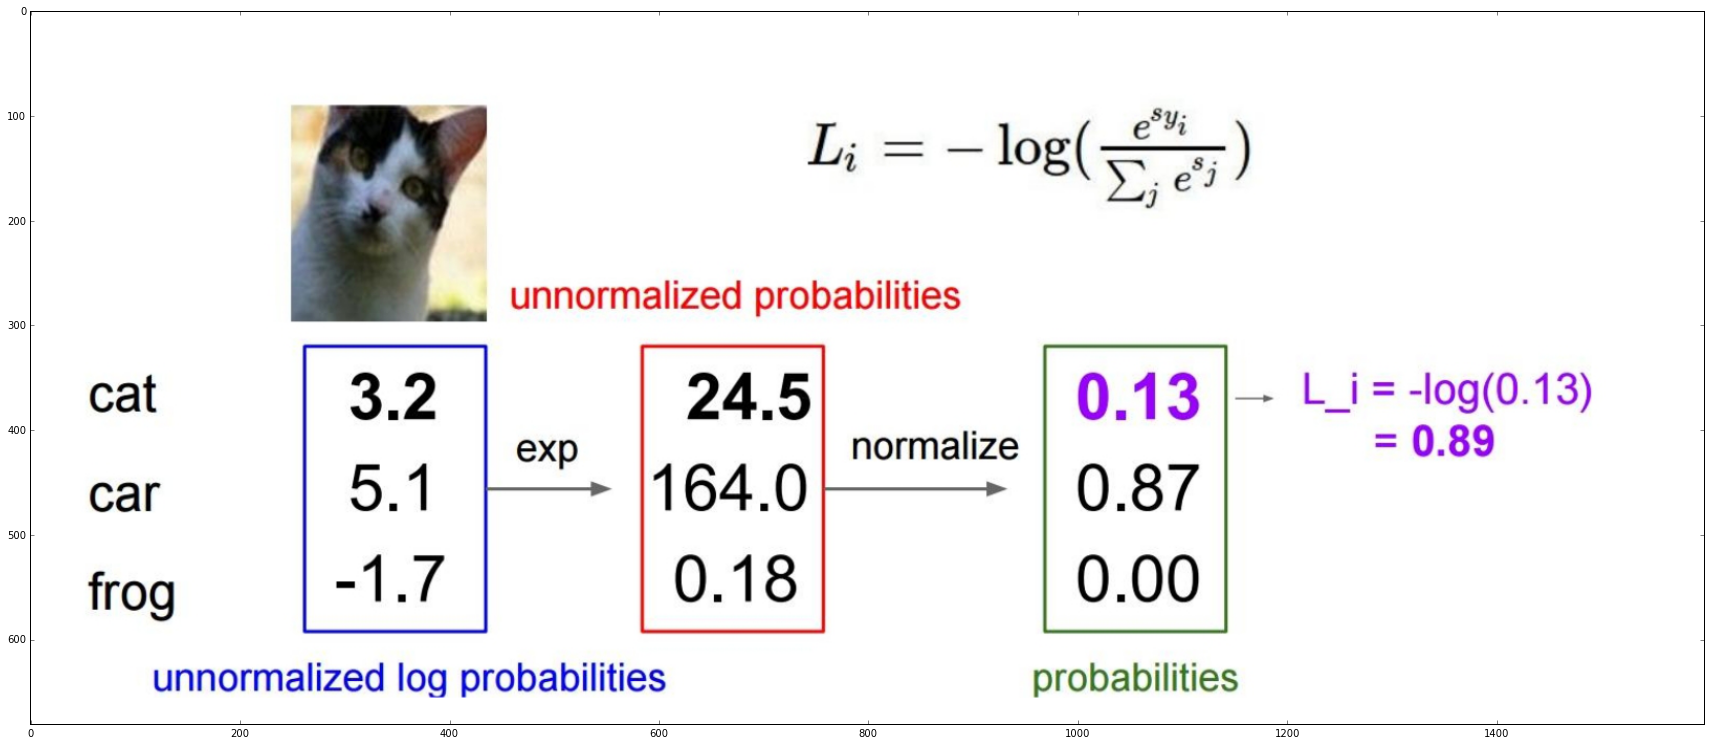

In [20]:
import matplotlib.image as mpimg
plt.figure(figsize = (30, 20))
img=mpimg.imread('softmax.jpg')
imgplot = plt.imshow(img)

# Are you not sleeping questions:

1) When will the loss function be equal to 0?

2) What happens if the correct class has probability 0?

3) What will be the loss function on the first iteration, assuming that you have 10 classes and you initialize the weights with random numbers drawn from an uniform distribution?

4) How can you use softmax classifier for binary class problems?

The structure of the SoftmaxClassifier class is very similar to that of the logistic regression class. We have a loss_function method which computes the cost function and the gradients, a method train which trains the classifier, method predict which does the inference, while the methods add_bias and test_accuracy are totally the same as in the LogisticRegression class.

In [23]:
class SoftmaxClassifier:
    def __init__(self, add_bias=True):
        self._theta = None
        self.add_bias = add_bias

    def loss_function(self, X, y, theta):
        """
           compute the softmax
           loss function and its gradient
           for the hypothesis the labels y.
           
           inputs:
           - y: the targets of the observations
           
           outputs:
           - the loss function
        """
   
        scores = X.dot(theta).T
        scores -= np.max(scores)
        exp_scores = np.exp(scores)
        
        exp_correct_scores = exp_scores[y, range(y.shape[0])]

        return np.mean(-np.log(exp_correct_scores / np.sum(exp_scores, axis=0)))

    
    def gradient(self, X, y, theta):
        """
           compute the gradient of the loss function
           for the observation matrix X and the labels y.
           
           inputs:
           - X: the observation matrix X
           - y: the targets of the observations
           
           outputs:
           - the gradient of the loss function
        """
        
        scores = X.dot(theta).T
        scores -= np.max(scores)
        exp_scores = np.exp(scores)

        p = exp_scores / np.sum(exp_scores, axis=0)
        ind = np.zeros(p.shape)
        ind[y, range(y.shape[0])] = 1.0
        
        return (1.0 / y.shape[0]) * np.dot((p - ind), X).T

    def train(self, X, y, alpha=1e-3, batch_size=200, tol=1e-5, max_iter=100, verbose=False):
        """
           train the classifier with the SGD method
           
           inputs:
           - X: the observation matrix X
           - y: the targets of the observations
           - alpha: the learning rate
           - batch_size: the size of a single batch
           - tol: the error tolerance
           - max_iter: the maximum number of iterations
           - verbose: if set to True the loss function is printed
                      to check if the algorithm is converging
        """
        if self.add_bias:
            X = np.hstack((np.ones((X.shape[0], 1)), X))

        num_classes = np.max(y) + 1  # assume y takes values 0...K-1 where K is number of classes      
        theta0 = 0.001 * np.random.randn(X.shape[1], num_classes)
        self._theta = SGD(X, y, alpha, self.gradient, self.loss_function, theta0, batch_size, tol,
            max_iter, verbose)
        
    def predict(self, X):
        """
        use the trained weights of this linear classifier to predict labels for
        data points.
        
        inputs:
        - X: D x N array of training data. Each column is a D-dimensional point.
        
        outputs:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
                  array of length N, and each element is an integer giving the predicted
                  class.
        """
        if self.add_bias:
            X = np.hstack((np.ones((X.shape[0], 1)), X))
        y_pred = np.zeros(X.shape[1])
        y_pred = np.argmax(X.dot(self._theta), axis=1)

        return y_pred

    def test_accuracy(self, predict, labels):
        return np.sum(labels == predict) / float(len(labels))

# Let's compare Softmax with Logistic Regression

In [24]:
labels_train = labels_train.astype(int)
l = SoftmaxClassifier()
l.train(haberman_train, labels_train, alpha=1e-1, tol=1e-5, max_iter=100, batch_size=200, verbose=True)
pred = l.predict(haberman_test)
accuracy = l.test_accuracy(pred, labels_test)
print("The accuracy is : %g" % accuracy)

Loss function at step 10 is: 0.504481
Loss function at step 20 is: 0.467219
Loss function at step 30 is: 0.455785
Loss function at step 40 is: 0.577792
Loss function at step 50 is: 0.449608
Loss function at step 60 is: 0.579491
Loss function at step 70 is: 0.579755
Loss function at step 80 is: 0.448065
Loss function at step 90 is: 0.58027
Loss function at step 100 is: 0.580351
The accuracy is : 0.839286


As expected, the accuracy is the same as before.

# Case study: MNIST dataset

MNIST dataset is arguably the most famous dataset in computer vision. It is a dataset consisting of handwritten digits of shape 28 by 28, grayscale. The dataset consists of 50000 training images and 20000 testing images. For around a decade MNIST has been the de facto computer vision dataset, and pretty much every experiment on computer vision has been applied there. To read more about MNIST, you can go in the following link: http://yann.lecun.com/exdb/mnist/

Below, we are going to load the training and testing set.

In [30]:
# load MNIST dataset
mnist = fetch_mldata('MNIST original')
data = mnist.data
labels = mnist.target
training_set = data[:50000, :]
testing_set = data[50000:, :]
training_labels = labels[:50000]
testing_labels = labels[50000:]
print(training_set.shape, testing_set.shape, training_labels.shape, testing_labels.shape)

((50000, 784), (20000, 784), (50000,), (20000,))


And then, we are going to standardize it, and print its statistics.

In [31]:
# preprocess the data
scaler = preprocessing.StandardScaler().fit(training_set)
training_set = scaler.transform(training_set)
testing_set = scaler.transform(testing_set)

# check if the mean and std are 0/1
print(np.mean(training_set), np.std(training_set), np.mean(testing_set), np.std(testing_set))

/home/revan/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/revan/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/revan/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(-1.7788038615769754e-18, 0.95564915430425768, 0.00087175673076846799, 1.1496268382997068)


Finally, we are going to train our softmax classifier on it, predict the labels on both the training set and testing set, and print the results

In [36]:
softmax = SoftmaxClassifier()
training_labels = training_labels.astype(int)
testing_labels = testing_labels.astype(int)
softmax.train(training_set, training_labels, alpha=1e-1, tol=-1.0, max_iter=10, batch_size=200, verbose=True)
y_train_pred = softmax.predict(training_set)
y_val_pred = softmax.predict(testing_set)
training_accuracy = np.mean(training_labels == y_train_pred)
validation_accuracy = np.mean(testing_labels == y_val_pred)
print("Training accuracy in M..0.....NIST is: %g" % training_accuracy)
print("Testing accuracy in MNIST is: %g" % validation_accuracy)

Loss function at step 1 is: 0.143736
Loss function at step 2 is: 0.137206
Loss function at step 3 is: 0.126467
Loss function at step 4 is: 0.0674338
Loss function at step 5 is: 0.256521
Loss function at step 6 is: 0.0618447
Loss function at step 7 is: 0.260843
Loss function at step 8 is: 0.0741133
Loss function at step 9 is: 0.176346
Loss function at step 10 is: 0.0956132
Training accuracy in MNIST is: 0.9469
Testing accuracy in MNIST is: 0.57675


# What is wrong?

The results on the training set and the testing set are very different, despite that we haven't done anything wrong.

In fact, this is to be expected. It is a very common (read: omnipresent) phenomenon in machine learning. Roughly speaking, overfitting means that the algorithm performs very well on the training set, but not as good in the testing set. Overfitting is the biggest problem on machine learning, and is studied a lot in the theory of generalizations. Struggling with overfitting is a part of everyday life for machine learning practitioners. While overfitting is a serious problem, there are methods to reduce it. The two most common methods (used in almost every machine learning algorithm) are:

    1) Regularization - briefly speaking, it is a way of penalizing the large weights. It is proven (Bayesian statistics strikes again) that small weights give better generalization performance. Regularization is a problem studied on machine learning, convex optimization (a special cose of multi objective function optimization) and Bayesian statistics (introducing priors). Finding the right regularization parameters is somewhere between a science and an art.
    
    2) Validation - instead of seperating the dataset into training and testing, we seperate it into training, validation and testing set. You train on the training set, see how good your results are in the validation set, and finally, test everything in the testing set. 
    
Regularization and Validation will be the topic of the next machine learning lecture in the group    

# What if the data is not linearly separable?

Logistic Regression and Softmax Classifier are linear classifiers. They won't be able to achieve perfect accuracy (even in training set) when the data is not linearly seperable. There are many approaches on fixing this problem:

    - Feature engineering: Generate better features and hope that the data will become seperable in a higher-dimensional feature space. It is one of the most annoying jobs ever, but very useful (and inevitable) in a lot of cases.
    - Kernelized logistic/softmax regression: Excellent mathematical properties, and like the original algorithms, give you probability scores instead of hard labels. O(n^3) complexity, not very used in practice.
    - Support Vector Machines: The most famous kernel algorithms and the king of classification algorithms during the last decade. O(n^2 * k) complexity (where k is the number of support vectors), but gives just hard scores instead of probability distributions. Beautiful mathematics but somehow expensive and nowadays not used as much as before. Likely to be covered in one of the future lessons.
    - Bagging and boosting: Ensemble methods, mostly tree-brased. Surprisingly good, and computationally cheap. Might be used as a baseline (a baseline that might be hard to beat) where the data is not very structured. 
    - Neural Networks aka Deep Learning: The hot right now (and in the future) classifiers. Very scalable (fast inference time), give probability distributions instead of hard scores and more importantly, work very well in practice, especially if the number of features is large, data is structured (like on images) and we have a lot of data. On the downside, training time is huge, and there aren't many theoretical properties. Neural Networks will be covered in several lectures.